In [ ]:
import pandas as pd
import json
import glob
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
pd.set_option('display.max_columns', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Pre-trained RoBERTa Embeddings


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from collections import Counter

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# ✅ Load data
train_val_df = pd.read_csv('/content/drive/MyDrive/Thesis/Final/pretrained_train_val_with_structured_final.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Thesis/Final/pretrained_test_with_structured_final.csv')

# ✅ Extract features and labels
X_train_val = train_val_df.iloc[:, :768].values
y_train_val = train_val_df['state_binary'].values

X_test = test_df.iloc[:, :768].values
y_test = test_df['state_binary'].values

# ✅ Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}

# ✅ Outer CV loop
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
outer_f1_scores = []
outer_auc_scores = []
best_params_per_fold = []

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_val, y_train_val)):
    print(f"\n🔁 Outer Fold {fold + 1}")

    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    # ✅ Inner CV with GridSearchCV
    model = LogisticRegression(penalty = 'l2', max_iter=1000, solver='liblinear', random_state=SEED)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params_per_fold.append(grid_search.best_params_['C'])

    # ✅ Evaluate on outer fold
    y_pred = best_model.predict(X_val)
    y_prob = best_model.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    outer_f1_scores.append(f1)
    outer_auc_scores.append(auc)

    print(f"Best C: {grid_search.best_params_['C']}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")

# ✅ Nested CV Summary
print("\n📊 Nested CV Results")
print(f"Average F1 Score: {np.mean(outer_f1_scores):.4f}")
print(f"Average AUC Score: {np.mean(outer_auc_scores):.4f}")

# ✅ Determine best C
best_fold_idx = np.argmax(outer_f1_scores)
best_C = best_params_per_fold[best_fold_idx]
print(f"\n🔧 Best fold was fold {best_fold_idx+1} with F1={outer_f1_scores[best_fold_idx]:.4f}, choosing C={best_C}")

# ✅ Train final model on all train_val data
final_model = LogisticRegression(
    C=best_C,
    penalty='l2',
    solver='liblinear',
    max_iter=1000,
    random_state=SEED
)
final_model.fit(X_train_val, y_train_val)

# ✅ Evaluate on the real test set
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

f1_test = f1_score(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_prob)

print("\n🧪 Final Evaluation on Held-Out Test Set")
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test AUC Score: {auc_test:.4f}")

# ✅ Label mapping
label_mapping = {1: 'successful', 0: 'failed'}
print("\nLabel mapping:", label_mapping)

# ✅ Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[1, 0])
print("\nConfusion Matrix (rows=actual, cols=predicted):")
print("                     Predicted Successful    Predicted Failed")
print(f"Actual Successful    {cm[0,0]:>8}               {cm[0,1]:>8}")
print(f"Actual Failed        {cm[1,0]:>8}               {cm[1,1]:>8}")

# ✅ (Optional) Detailed classification report
print("\nClassification Report:")
print(classification_report(
    y_test, y_test_pred, target_names=['failed','successful']
))



🔁 Outer Fold 1
Best C: 0.1
F1 Score: 0.8043
AUC Score: 0.8070

🔁 Outer Fold 2
Best C: 0.1
F1 Score: 0.8036
AUC Score: 0.8023

🔁 Outer Fold 3
Best C: 0.1
F1 Score: 0.8028
AUC Score: 0.8003

🔁 Outer Fold 4
Best C: 0.1
F1 Score: 0.8016
AUC Score: 0.8007

🔁 Outer Fold 5
Best C: 0.1
F1 Score: 0.8007
AUC Score: 0.7990

📊 Nested CV Results
Average F1 Score: 0.8026
Average AUC Score: 0.8018

🔧 Best fold was fold 1 with F1=0.8043, choosing C=0.1

🧪 Final Evaluation on Held-Out Test Set
Test F1 Score: 0.8076
Test AUC Score: 0.8038

Label mapping: {1: 'successful', 0: 'failed'}

Confusion Matrix (rows=actual, cols=predicted):
                     Predicted Successful    Predicted Failed
Actual Successful        8493                   1423
Actual Failed            2624                   3693

Classification Report:
              precision    recall  f1-score   support

      failed       0.72      0.58      0.65      6317
  successful       0.76      0.86      0.81      9916

    accuracy        

##Fine-tuned RoBERTa Embeddings

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report
from collections import Counter

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# ✅ Load data
train_val_df = pd.read_csv('/content/drive/MyDrive/Thesis/Final/finetuned_train_val_with_structured_final.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Thesis/Final/finetuned_test_with_structured_final.csv')

# ✅ Extract features and labels
X_train_val = train_val_df.iloc[:, :768].values
y_train_val = train_val_df['state_binary'].values

X_test = test_df.iloc[:, :768].values
y_test = test_df['state_binary'].values

# ✅ Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}

# ✅ Outer CV loop
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
outer_f1_scores = []
outer_auc_scores = []
best_params_per_fold = []

for fold, (train_idx, val_idx) in enumerate(outer_cv.split(X_train_val, y_train_val)):
    print(f"\n🔁 Outer Fold {fold + 1}")

    X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
    y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

    # ✅ Inner CV with GridSearchCV
    model = LogisticRegression(penalty = 'l2', max_iter=1000, solver='liblinear', random_state=SEED)
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

    grid_search = GridSearchCV(
        model,
        param_grid,
        cv=inner_cv,
        scoring='f1',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params_per_fold.append(grid_search.best_params_['C'])

    # ✅ Evaluate on outer fold
    y_pred = best_model.predict(X_val)
    y_prob = best_model.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    outer_f1_scores.append(f1)
    outer_auc_scores.append(auc)

    print(f"Best C: {grid_search.best_params_['C']}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")

# ✅ Nested CV Summary
print("\n📊 Nested CV Results")
print(f"Average F1 Score: {np.mean(outer_f1_scores):.4f}")
print(f"Average AUC Score: {np.mean(outer_auc_scores):.4f}")

# ✅ Determine best C
best_fold_idx = np.argmax(outer_f1_scores)
best_C = best_params_per_fold[best_fold_idx]
print(f"\n🔧 Best fold was fold {best_fold_idx+1} with F1={outer_f1_scores[best_fold_idx]:.4f}, choosing C={best_C}")

# ✅ Train final model on all train_val data
final_model = LogisticRegression(
    C=best_C,
    penalty='l2',
    solver='liblinear',
    max_iter=1000,
    random_state=SEED
)
final_model.fit(X_train_val, y_train_val)

# ✅ Evaluate on the real test set
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

f1_test = f1_score(y_test, y_test_pred)
auc_test = roc_auc_score(y_test, y_test_prob)

print("\n🧪 Final Evaluation on Held-Out Test Set")
print(f"Test F1 Score: {f1_test:.4f}")
print(f"Test AUC Score: {auc_test:.4f}")

# ✅ Label mapping
label_mapping = {1: 'successful', 0: 'failed'}
print("\nLabel mapping:", label_mapping)

# ✅ Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[1, 0])
print("\nConfusion Matrix (rows=actual, cols=predicted):")
print("                     Predicted Successful    Predicted Failed")
print(f"Actual Successful    {cm[0,0]:>8}               {cm[0,1]:>8}")
print(f"Actual Failed        {cm[1,0]:>8}               {cm[1,1]:>8}")

# ✅ (Optional) Detailed classification report
print("\nClassification Report:")
print(classification_report(
    y_test, y_test_pred, target_names=['failed','successful']
))



🔁 Outer Fold 1
Best C: 0.001
F1 Score: 0.8605
AUC Score: 0.8964

🔁 Outer Fold 2
Best C: 0.01
F1 Score: 0.8590
AUC Score: 0.8961

🔁 Outer Fold 3
Best C: 0.01
F1 Score: 0.8581
AUC Score: 0.8939

🔁 Outer Fold 4
Best C: 0.001
F1 Score: 0.8606
AUC Score: 0.8945

🔁 Outer Fold 5
Best C: 0.01
F1 Score: 0.8607
AUC Score: 0.8982

📊 Nested CV Results
Average F1 Score: 0.8598
Average AUC Score: 0.8958

🔧 Best fold was fold 5 with F1=0.8607, choosing C=0.01

🧪 Final Evaluation on Held-Out Test Set
Test F1 Score: 0.8208
Test AUC Score: 0.8418

Label mapping: {1: 'successful', 0: 'failed'}

Confusion Matrix (rows=actual, cols=predicted):
                     Predicted Successful    Predicted Failed
Actual Successful        8377                   1539
Actual Failed            2118                   4199

Classification Report:
              precision    recall  f1-score   support

      failed       0.73      0.66      0.70      6317
  successful       0.80      0.84      0.82      9916

    accuracy

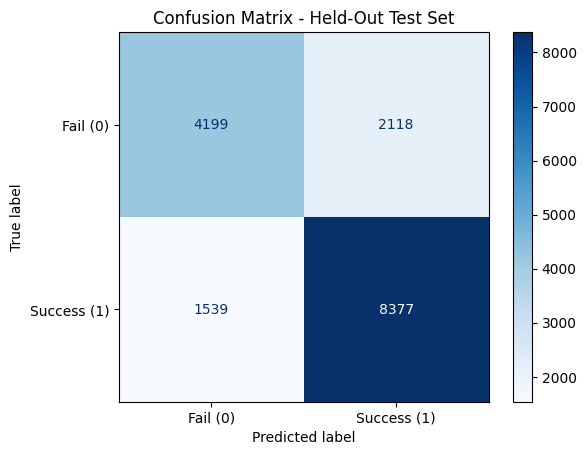


📋 Classification Report (3 decimal points):

              precision    recall  f1-score   support

    Fail (0)      0.732     0.665     0.697      6317
 Success (1)      0.798     0.845     0.821      9916

    accuracy                          0.775     16233
   macro avg      0.765     0.755     0.759     16233
weighted avg      0.772     0.775     0.773     16233



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fail (0)', 'Success (1)'])
disp.plot(cmap='Blues')

plt.title("Confusion Matrix - Held-Out Test Set")
plt.grid(False)
plt.show()

# ✅ Classification Report
report = classification_report(
    y_test,
    y_test_pred,
    target_names=['Fail (0)', 'Success (1)'],
    digits=3
)

print("\n📋 Classification Report (3 decimal points):\n")
print(report)
